<a href="https://colab.research.google.com/github/prudvinathmalepati/machine-learning/blob/main/module2/assignments/week4/multi_class_text_classification_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi class text classification

[Tutorial for this coding exercise](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)

In [1]:
#Load Data from Google Drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
import pandas as pd
df_path = 'gdrive/My Drive/consumer_complaints.csv'
df = pd.read_csv(df_path)
df.head()

Mounted at /content/gdrive


<ipython-input-1-6f6a8445101d>:7: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


## Data Exploration
For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

    Input: Consumer_complaint_narrative

Example: “ I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”

    Output: product

Example: Credit reporting

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.

We also create a couple of dictionaries for future use.

In [2]:
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  consumer_consent_provided     66806 non-null  object
 12  submitted_via                 66806 non-null  object
 13  date_sent_

In [4]:
col = ['product', 'consumer_complaint_narrative']
df = df[col]

In [5]:
df.columns

Index(['product', 'consumer_complaint_narrative'], dtype='object')

In [6]:
#Just renaming the columns
df.columns = ['Product', 'Consumer_complaint_narrative']

In [7]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [8]:
df.head()

,Product,Consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [10]:
df = df.sample(5000)

In [26]:
df.head()

,Product,Consumer_complaint_narrative,category_id
226470,Debt collection,XXXX is attempting to collect on a debt for an...,0
218387,Mortgage,I was recently notified that I was denied for ...,2
297063,Mortgage,CitiMortgage approved a loan modification XX/X...,2
536336,Mortgage,"This file was opened 27 weeks ago in XXXX, the...",2
307423,Credit card,"My wife and I were at a hotel in South Dakota,...",3


### Imbalanced Classes

We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Credit reporting and Mortgage.

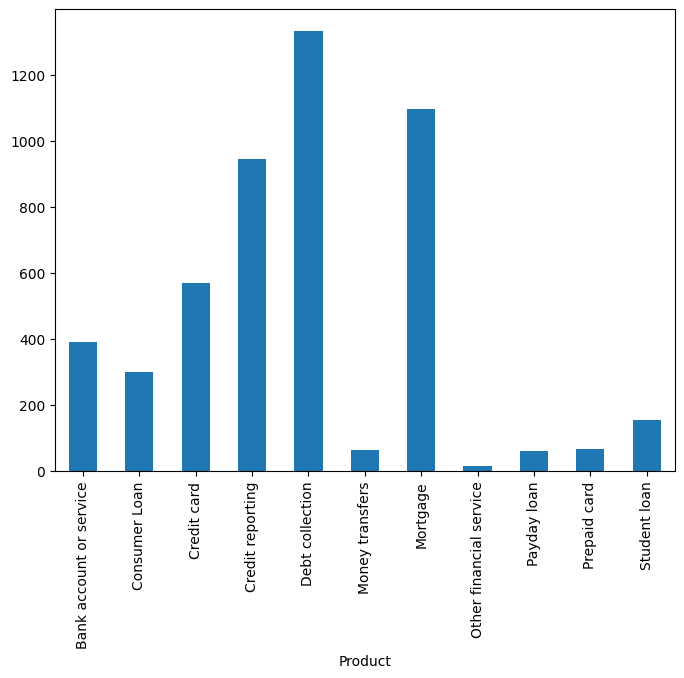

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

## Text Representation

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:

    sublinear_df is set to True to use a logarithmic form for frequency.
    min_df is the minimum numbers of documents a word must be present in to be kept.
    norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
    ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
    stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(5000, 13567)

We will use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:

In [15]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . overdraft
  . Most correlated bigrams:
       . checking account
       . savings account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . car payment
       . auto loan
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . credit file
       . credit report
# 'Debt collection':
  . Most correlated unigrams:
       . collection
       . debt
  . Most correlated bigrams:
       . collect debt
       . collection agency
# 'Money transfers':
  . Most correlated unigrams:
       . gram
       . moneygram
  . Most correlated bigrams:
       . money gram
       . western union
# 'Mortgage':
  . Most correlated unigrams:
      

After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

    Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the training set, let’s make some predictions.

In [29]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [39]:
print(clf.predict(count_vect.transform(["This file was opened 27 weeks ago in XXXX, the online platform used to negotiate short sales. Since that time, though the file has gone to underwriting five times, the file has yet to be deemed a complete file. Nationstar appears to be reviewing single documents or single pages of documents instead of an entire file. I have persistently asked that this file be considered 'complete ' for a short sale. I have submitted files and documents for months! Time to make this a complete file."])))

['Mortgage']


## Model Selection
We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:

    Logistic Regression
    (Multinomial) Naive Bayes
    Linear Support Vector Machine
    Random Forest

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

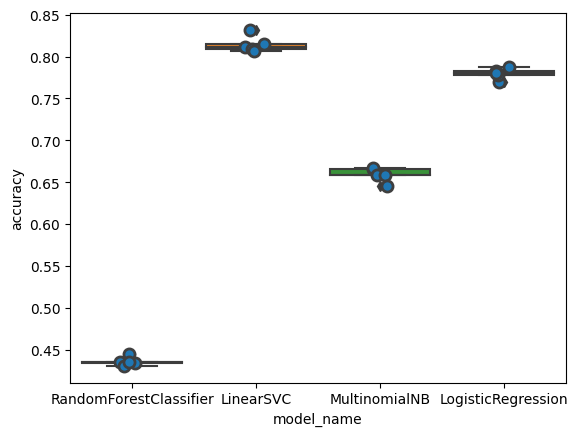

In [42]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [43]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.8148
LogisticRegression        0.7798
MultinomialNB             0.6592
RandomForestClassifier    0.4362
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 81.5%.

## Model Evaluation

Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

In [44]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

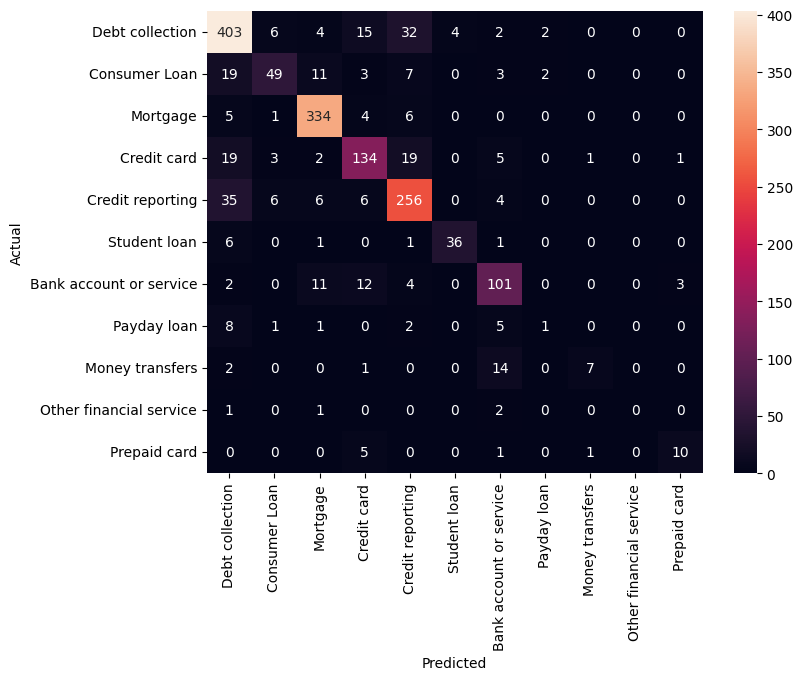

In [45]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [46]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Debt collection' : 19 examples.


,Product,Consumer_complaint_narrative
514850,Consumer Loan,GM Finance called a friend of min who is the c...
490723,Consumer Loan,I was paying on a collections that was on my c...
325294,Consumer Loan,I was in debt for about {$20000.00} in XX/XX/X...
201989,Consumer Loan,In XX/XX/XXXX I was mailed a check and paperwo...
243719,Consumer Loan,Paid off loan XX/XX/XXXX or XX/XX/XXXX. Have b...
524539,Consumer Loan,Glennon Law Firm LLC was hired by XXXX XXXX to...
238045,Consumer Loan,a debt collector from consumer portfolio ( cps...
508959,Consumer Loan,American Honda Finance Corporation deducted tw...
272972,Consumer Loan,My son was XXXX and I informed the company tha...
206966,Consumer Loan,Received Stop Release due to garnishment and c...



'Credit card' predicted as 'Debt collection' : 19 examples.


,Product,Consumer_complaint_narrative
286962,Credit card,In XXXX of 2015 I wrote to my card company abo...
258348,Credit card,I pay my balance in full every month prior to ...
527970,Credit card,"on XXXX XX/XX/2015, i have noticed that Americ..."
529113,Credit card,This phone number XXXX has been reported and I...
213414,Credit card,"The original creditor, Wells Fargo Bank, sold ..."
310924,Credit card,I contacted XXXX about a couple months ago and...
240705,Credit card,"For months, BOA had been calling and I inform ..."
510723,Credit card,My first statement from the company was sent d...
227992,Credit card,hsbc now has made it real hard to reach. i spe...
541971,Credit card,My husband lost his job and I was unable to pa...



'Credit reporting' predicted as 'Debt collection' : 35 examples.


,Product,Consumer_complaint_narrative
497965,Credit reporting,Contacted XXXX regarding a medical collection ...
548963,Credit reporting,Debt was paid in full on XXXX/XXXX/16 ( see at...
518326,Credit reporting,the amount owed on my credit report is not cor...
270255,Credit reporting,When my ex husband kicked me out of his house ...
200892,Credit reporting,My credit report reflects an account in collec...
239052,Credit reporting,Sent creditor copy of discharge notice but hav...
298210,Credit reporting,does not belong to me please remove medical XX...
323761,Credit reporting,I have put in disputes through the credit bure...
287706,Credit reporting,Listed on my credit report from Equafax is a c...
216542,Credit reporting,"XXXX has filed a "" Collections Account '' on m..."



'Student loan' predicted as 'Debt collection' : 6 examples.


,Product,Consumer_complaint_narrative
303116,Student loan,I contacted Navient back in XXXX XXXX 2015 to ...
269338,Student loan,"XXXX of XXXX, Fl, I got this loan in XX/XX/XXX..."
297593,Student loan,"XX/XX/XXXXThe following company, XXXX XXXX XXX..."
502952,Student loan,The loan was opened in XXXX XXXX and defaulted...
251595,Student loan,I have defaulted on a student loan from nation...
237942,Student loan,NAVINT has a debt against me. my concern is XX...



'Payday loan' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
249123,Payday loan,I asked Greenback Recovery Group to stop calli...
237947,Payday loan,A outside collection agency told me to make a ...
275055,Payday loan,Today I received a bill in the US mail from Pa...
540811,Payday loan,I received a call from Dollar Loan Center abou...
498241,Payday loan,I have been receiving harassing threatening ph...
506792,Payday loan,XXXX ID : XXXX CASE FILE # : NT - XXXX LOAN IN...
232817,Payday loan,I was told their was XXXX intial fiance fee of...
221552,Payday loan,i have numerous emails that have come thru my ...



'Debt collection' predicted as 'Consumer Loan' : 6 examples.


,Product,Consumer_complaint_narrative
316339,Debt collection,XXXX XXXX XXXX purchased my debt from Capital ...
300428,Debt collection,I 'm being charge a amount of {$1900.00} for s...
212983,Debt collection,I was contacted by this person that claimed he...
304546,Debt collection,I was in a car accident in XXXX 2013. The car ...
535232,Debt collection,Over the past several months beginning in XXXX...
538979,Debt collection,The seller of the auto USA Santander Consumer ...



'Credit reporting' predicted as 'Consumer Loan' : 6 examples.


,Product,Consumer_complaint_narrative
215954,Credit reporting,I traded in a car I had financed through XXXX ...
273801,Credit reporting,"that debt did not belong to me, to my understa..."
326876,Credit reporting,"XX/XX/2007, my name was listed second on a loa..."
254155,Credit reporting,My loan from XXXX for {$36000.00} is no longer...
257491,Credit reporting,XXXX employees caused a dent into my car while...
271021,Credit reporting,This ticket was actually my sons while driving...



'Consumer Loan' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint_narrative
262142,Consumer Loan,Around XXXX 2005 My wife and I purchased a hom...
550458,Consumer Loan,I am XXXX in the Texas XXXX XXXX and not on XX...
279600,Consumer Loan,Ocwenloans took over a loan we had. When we we...
217657,Consumer Loan,I took out a loan with XXXX XXXX finance in XX...
235401,Consumer Loan,I am currently waiting on approval on a home m...
265483,Consumer Loan,I am 3+ years into a 5-year auto loan with BBV...
497635,Consumer Loan,the lease with american honda finance was disc...
237766,Consumer Loan,"I went through this awhile back, Bank of Ameri..."
325358,Consumer Loan,CashCall Loan This loan was taken in XXXX of 2...
244552,Consumer Loan,I purchased a XXXX through a XXXX dealer and f...



'Credit reporting' predicted as 'Mortgage' : 6 examples.


,Product,Consumer_complaint_narrative
550375,Credit reporting,On XXXX 2011 my wife and I sold our Florida ap...
238177,Credit reporting,XXXX XXXX XXXX XXXX XXXX XXXX Md XXXXMy loan t...
279346,Credit reporting,XXXX XXXX XXXX XXXX Home Equity Line of Credit...
291552,Credit reporting,I have disputed this in the past with this com...
326743,Credit reporting,I had a school loan that I payed on time for 6...
224220,Credit reporting,Your VerificationNow we just need to make sure...



'Bank account or service' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint_narrative
299618,Bank account or service,I spoke with XXXX XXXX form Bank America on XX...
262433,Bank account or service,"Bank of America, after my previous complaint, ..."
302083,Bank account or service,i was a victim of scam which many times i have...
244553,Bank account or service,The Bank of Oklahoma trust department has been...
223746,Bank account or service,"BB & T, specifically XXXX XXXX who is XXXX of ..."
318176,Bank account or service,I hired all state vanlines to move me from XXX...
504221,Bank account or service,I 'm house wife and not involved husband 's bu...
547797,Bank account or service,I want to get my last name changed back to my ...
532651,Bank account or service,I am XXXX yrs old. Live on fix icome. I could ...
297076,Bank account or service,"On XXXX XXXX, 2009, a large home, worth about ..."



'Debt collection' predicted as 'Credit card' : 15 examples.


,Product,Consumer_complaint_narrative
277471,Debt collection,I have been a victim of identity theft. I had ...
519377,Debt collection,American Express closed my account with approx...
258236,Debt collection,I took out credit card as a XXXX. The card had...
512718,Debt collection,Midland mailed a post card to me that anyone c...
251152,Debt collection,"AMERICAN EXPRESS CARD KEPT CALLING, SKIP TRACI..."
206854,Debt collection,I did not receive this service that I am being...
522896,Debt collection,I do not owe any credit card with this institu...
277227,Debt collection,I had setup a payment plan in XXXX 2015 to rep...
502327,Debt collection,My wife made a purchase at Kohls in XXXX. Indi...
491334,Debt collection,XXXX XXXX I was approved on an individual basi...



'Credit reporting' predicted as 'Credit card' : 6 examples.


,Product,Consumer_complaint_narrative
503905,Credit reporting,Equifax has XXXX Bank XXXX credit card account...
232010,Credit reporting,1. at this time. home depot is paid in full. i...
271385,Credit reporting,The account with The XXXX XXXX ( XXXX ) is not...
234745,Credit reporting,Credit indebtedness had been satisfied and yet...
283913,Credit reporting,Called XXXX and the associate told me that as ...
310555,Credit reporting,I am current on my credit cards and paying pay...



'Bank account or service' predicted as 'Credit card' : 12 examples.


,Product,Consumer_complaint_narrative
244482,Bank account or service,Synchrony Bank charged my account a withholdin...
240477,Bank account or service,It has been the longest while since I have had...
490034,Bank account or service,"I received a letter on XXXX XXXX, 2016 stating..."
532611,Bank account or service,Discover Bank mailed flyers to Discover Credit...
503759,Bank account or service,"A while back I signed up with Bank of America,..."
303204,Bank account or service,Merchant ID XXXXLease # XXXXWe took what was s...
287580,Bank account or service,"I was offered a pre-qualified "" Business Line ..."
245533,Bank account or service,I filed a dispute with Bank of America regardi...
500318,Bank account or service,XXXX XXXX from the office of the president for...
224271,Bank account or service,I have not received an Interest Statement for ...



'Debt collection' predicted as 'Credit reporting' : 32 examples.


,Product,Consumer_complaint_narrative
191015,Debt collection,a incorrect reporting by cavalry portfolio on ...
551321,Debt collection,"Cach , LLC is reporting an account on my credi..."
258305,Debt collection,"Debt was not mine, was removed years ago after..."
517080,Debt collection,I no longer want to dispute this account becau...
268512,Debt collection,"Scott Parnell & Associates, PC. 's ( XXXX ) At..."
519970,Debt collection,I was told by Medical Business Bureau that onc...
228064,Debt collection,"On XXXX XXXX, 2014 my daughter started an Appl..."
324167,Debt collection,On this account I made my request for validati...
498804,Debt collection,"this item is listed as "" charged off '' and I ..."
272771,Debt collection,I am have been charged with an owed amount on ...



'Consumer Loan' predicted as 'Credit reporting' : 7 examples.


,Product,Consumer_complaint_narrative
245101,Consumer Loan,"I, XXXX XXXX XXXX give permission to assist me..."
264030,Consumer Loan,Roadlloans.com did a hard credit inquiry on my...
265443,Consumer Loan,Capital One Auto Finance is reporting a reposs...
533672,Consumer Loan,Honda advertises no money down lease on new Ci...
320781,Consumer Loan,My credit report still showing an auto loan wh...
496410,Consumer Loan,"Loan were charge off, went to collection ... h..."
507408,Consumer Loan,I applied for credit with XXXX XXXX expecting ...



'Mortgage' predicted as 'Credit reporting' : 6 examples.


,Product,Consumer_complaint_narrative
234576,Mortgage,Veterans United employee XXXX XXXX pulled my c...
296368,Mortgage,made a prepayment plan for XXXX payment to be ...
311964,Mortgage,Was told needed XXXX items ( conditions ) then...
240534,Mortgage,I have written to Statebridge Compnay at least...
515253,Mortgage,Ocwen Mortgage is incorrectly reporting my cre...
236305,Mortgage,Please see the attached XXXX Page Scanned Docu...



'Credit card' predicted as 'Credit reporting' : 19 examples.


,Product,Consumer_complaint_narrative
258246,Credit card,I never had any credit cards opened in my name...
501012,Credit card,I have checked my credit report from XXXX and ...
256177,Credit card,American Express is reporting an account on my...
247649,Credit card,On XX/XX/2014 I received a letter from Care Cr...
291507,Credit card,Pulled credit report without permission \n
281261,Credit card,Bank of America is falsely reporting to credit...
291852,Credit card,I was using my PayPal account to purchase an i...
499028,Credit card,THIS ACCOUNT XXXX THE REST OF THE ACCOUNT NUMB...
259510,Credit card,I HAVE A HARD INQUIRE ON MY CREDIT REPORT THAT...
238217,Credit card,"While checking my personal credit report, whic..."



'Money transfers' predicted as 'Bank account or service' : 14 examples.


,Product,Consumer_complaint_narrative
308820,Money transfers,I opened a PayPal account XX/XX/XXXX for an eB...
215844,Money transfers,Made a domestic wire transfer from Citibank to...
231465,Money transfers,Subscription service was cancelled with mercha...
248884,Money transfers,google wallet has cancled my account with {$14...
273942,Money transfers,I received a call from someone saying they wer...
248044,Money transfers,A funds transfer in the amount of XXXX was req...
213890,Money transfers,On XXXX XXXX 2015 I when online into my Paypal...
549931,Money transfers,"My daughter set me up as a payee in PNC 's "" p..."
493106,Money transfers,My daughter requests her rent payment from me ...
520339,Money transfers,On XXXX/XXXX/2014 I made XXXX wire transfers t...


we use the chi-squared test to find the terms that are the most correlated with each of the categories:

In [47]:
model.fit(features, labels)

LinearSVC()

In [49]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . debit card
       . savings account
# 'Consumer Loan':
  . Top unigrams:
       . car
       . vehicle
  . Top bigrams:
       . pay loan
       . hard inquires
# 'Credit card':
  . Top unigrams:
       . card
       . capital
  . Top bigrams:
       . credit card
       . card services
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx xxxx
       . trans union
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . owe credit
       . debt xxxx
# 'Money transfers':
  . Top unigrams:
       . moneygram
       . money
  . Top bigrams:
       . western union
       . money gram
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . escrow
  . Top bigrams:
       . short sale
       . green tree
# 'Other financial service':
  . Top unigrams:
       . passport
       . employee
  . To

In [50]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Mortgage'

"I can't get the money out of the country."
  - Predicted as: 'Debt collection'

"I have no money to pay my tuition"
  - Predicted as: 'Student loan'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Credit card'



Finally, we print out the classification report for each class:

In [51]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.81      0.86      0.83       468
               Mortgage       0.74      0.52      0.61        94
            Credit card       0.90      0.95      0.93       350
Bank account or service       0.74      0.73      0.74       184
       Credit reporting       0.78      0.82      0.80       313
           Student loan       0.90      0.80      0.85        45
           Prepaid card       0.73      0.76      0.75       133
          Consumer Loan       0.20      0.06      0.09        18
            Payday loan       0.78      0.29      0.42        24
        Money transfers       0.00      0.00      0.00         4
Other financial service       0.71      0.59      0.65        17

               accuracy                           0.81      1650
              macro avg       0.66      0.58      0.61      1650
           weighted avg       0.80      0.81      0.80      1650



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
